## Multivariate Normal example

In [1]:
import torch
import torch.distributions as tdist

from torchns import NestedSampler, GaussianPrior

import matplotlib.pyplot as plt
from corner import corner

torch.manual_seed(22)

Define model (Multivariate Normal Likelihood with Multivariate Normal Prior) and sample data:

- Prior: $p(\boldsymbol \vartheta)=\mathcal{N}(\mathbf 0, \mathbf{\Sigma_0})$

- Likelihood: $p(\mathbf x \mid \boldsymbol \vartheta)= \mathcal{N}(\boldsymbol \vartheta, \mathbf{\Sigma})$

- Posterior: $p(\boldsymbol \vartheta \mid \mathbf x)= \cfrac{p(\mathbf x \mid \boldsymbol \vartheta)}{p(\mathbf x)}p(\boldsymbol \vartheta) \propto \mathcal{N}((\mathbf{\Sigma}^{-1}+\mathbf{\Sigma}_0^{-1})^{-1} \mathbf{\Sigma}^{-1} \mathbf x, (\mathbf{\Sigma}^{-1}+\mathbf{\Sigma}_0^{-1})^{-1})$

In [2]:
# Dimensions
dim = 5

# Prior
prior_mu = torch.zeros(dim)
prior_cov = torch.eye(dim) * 0.1
prior_std = torch.sqrt(torch.diagonal(prior_cov))
prior_transform = GaussianPrior(mean=prior_mu, sigma=prior_std)
prior = tdist.MultivariateNormal(loc=prior_mu, covariance_matrix=prior_cov)
PARAMETERS = prior.sample()

# Likelihood
likelihood_mu = PARAMETERS
likelihood_cov = torch.ones((dim, dim)) * 0.03**2
torch.diagonal(likelihood_cov).fill_((0.05)**2)
likelihood = tdist.MultivariateNormal(loc=likelihood_mu, covariance_matrix=likelihood_cov)
DATA = likelihood.sample()

# Posterior
post_cov = torch.inverse(
    torch.inverse(prior_cov) + torch.inverse(likelihood_cov)
    )
post_mu = torch.matmul(
            post_cov,
            (
                torch.matmul(
                    torch.inverse(likelihood_cov), DATA.reshape(-1)
                )

            ),
        )
posterior = tdist.MultivariateNormal(loc=post_mu, covariance_matrix=post_cov)

Sample initial live points from the prior and move them to the hypercube

In [3]:
X_init = prior.sample((10_000,))
X_init = prior_transform.v_to_u(X_init)

Define the likelihood callable:

In [4]:
def log_likelihood(X_u, prior_transform):
    X_v = prior_transform.u_to_v(X_u).to(X_u.device)
    likelihood = tdist.MultivariateNormal(loc=X_v, covariance_matrix=likelihood_cov)
    return likelihood.log_prob(DATA)

Create the nested sampler class and run it

In [5]:
ns = NestedSampler(X_init)
ns.nested_sampling(
    lambda X: log_likelihood(X, prior_transform),
    epsilon = 1e-3, 
    num_batch_samples=100, 
    samples_per_slice=20, 
    num_steps=5
)

  0%|          | 0/100000 [00:00<?, ?it/s]

Get posterior samples and compare it to the analytical solution

N_eff: 56781.56640625


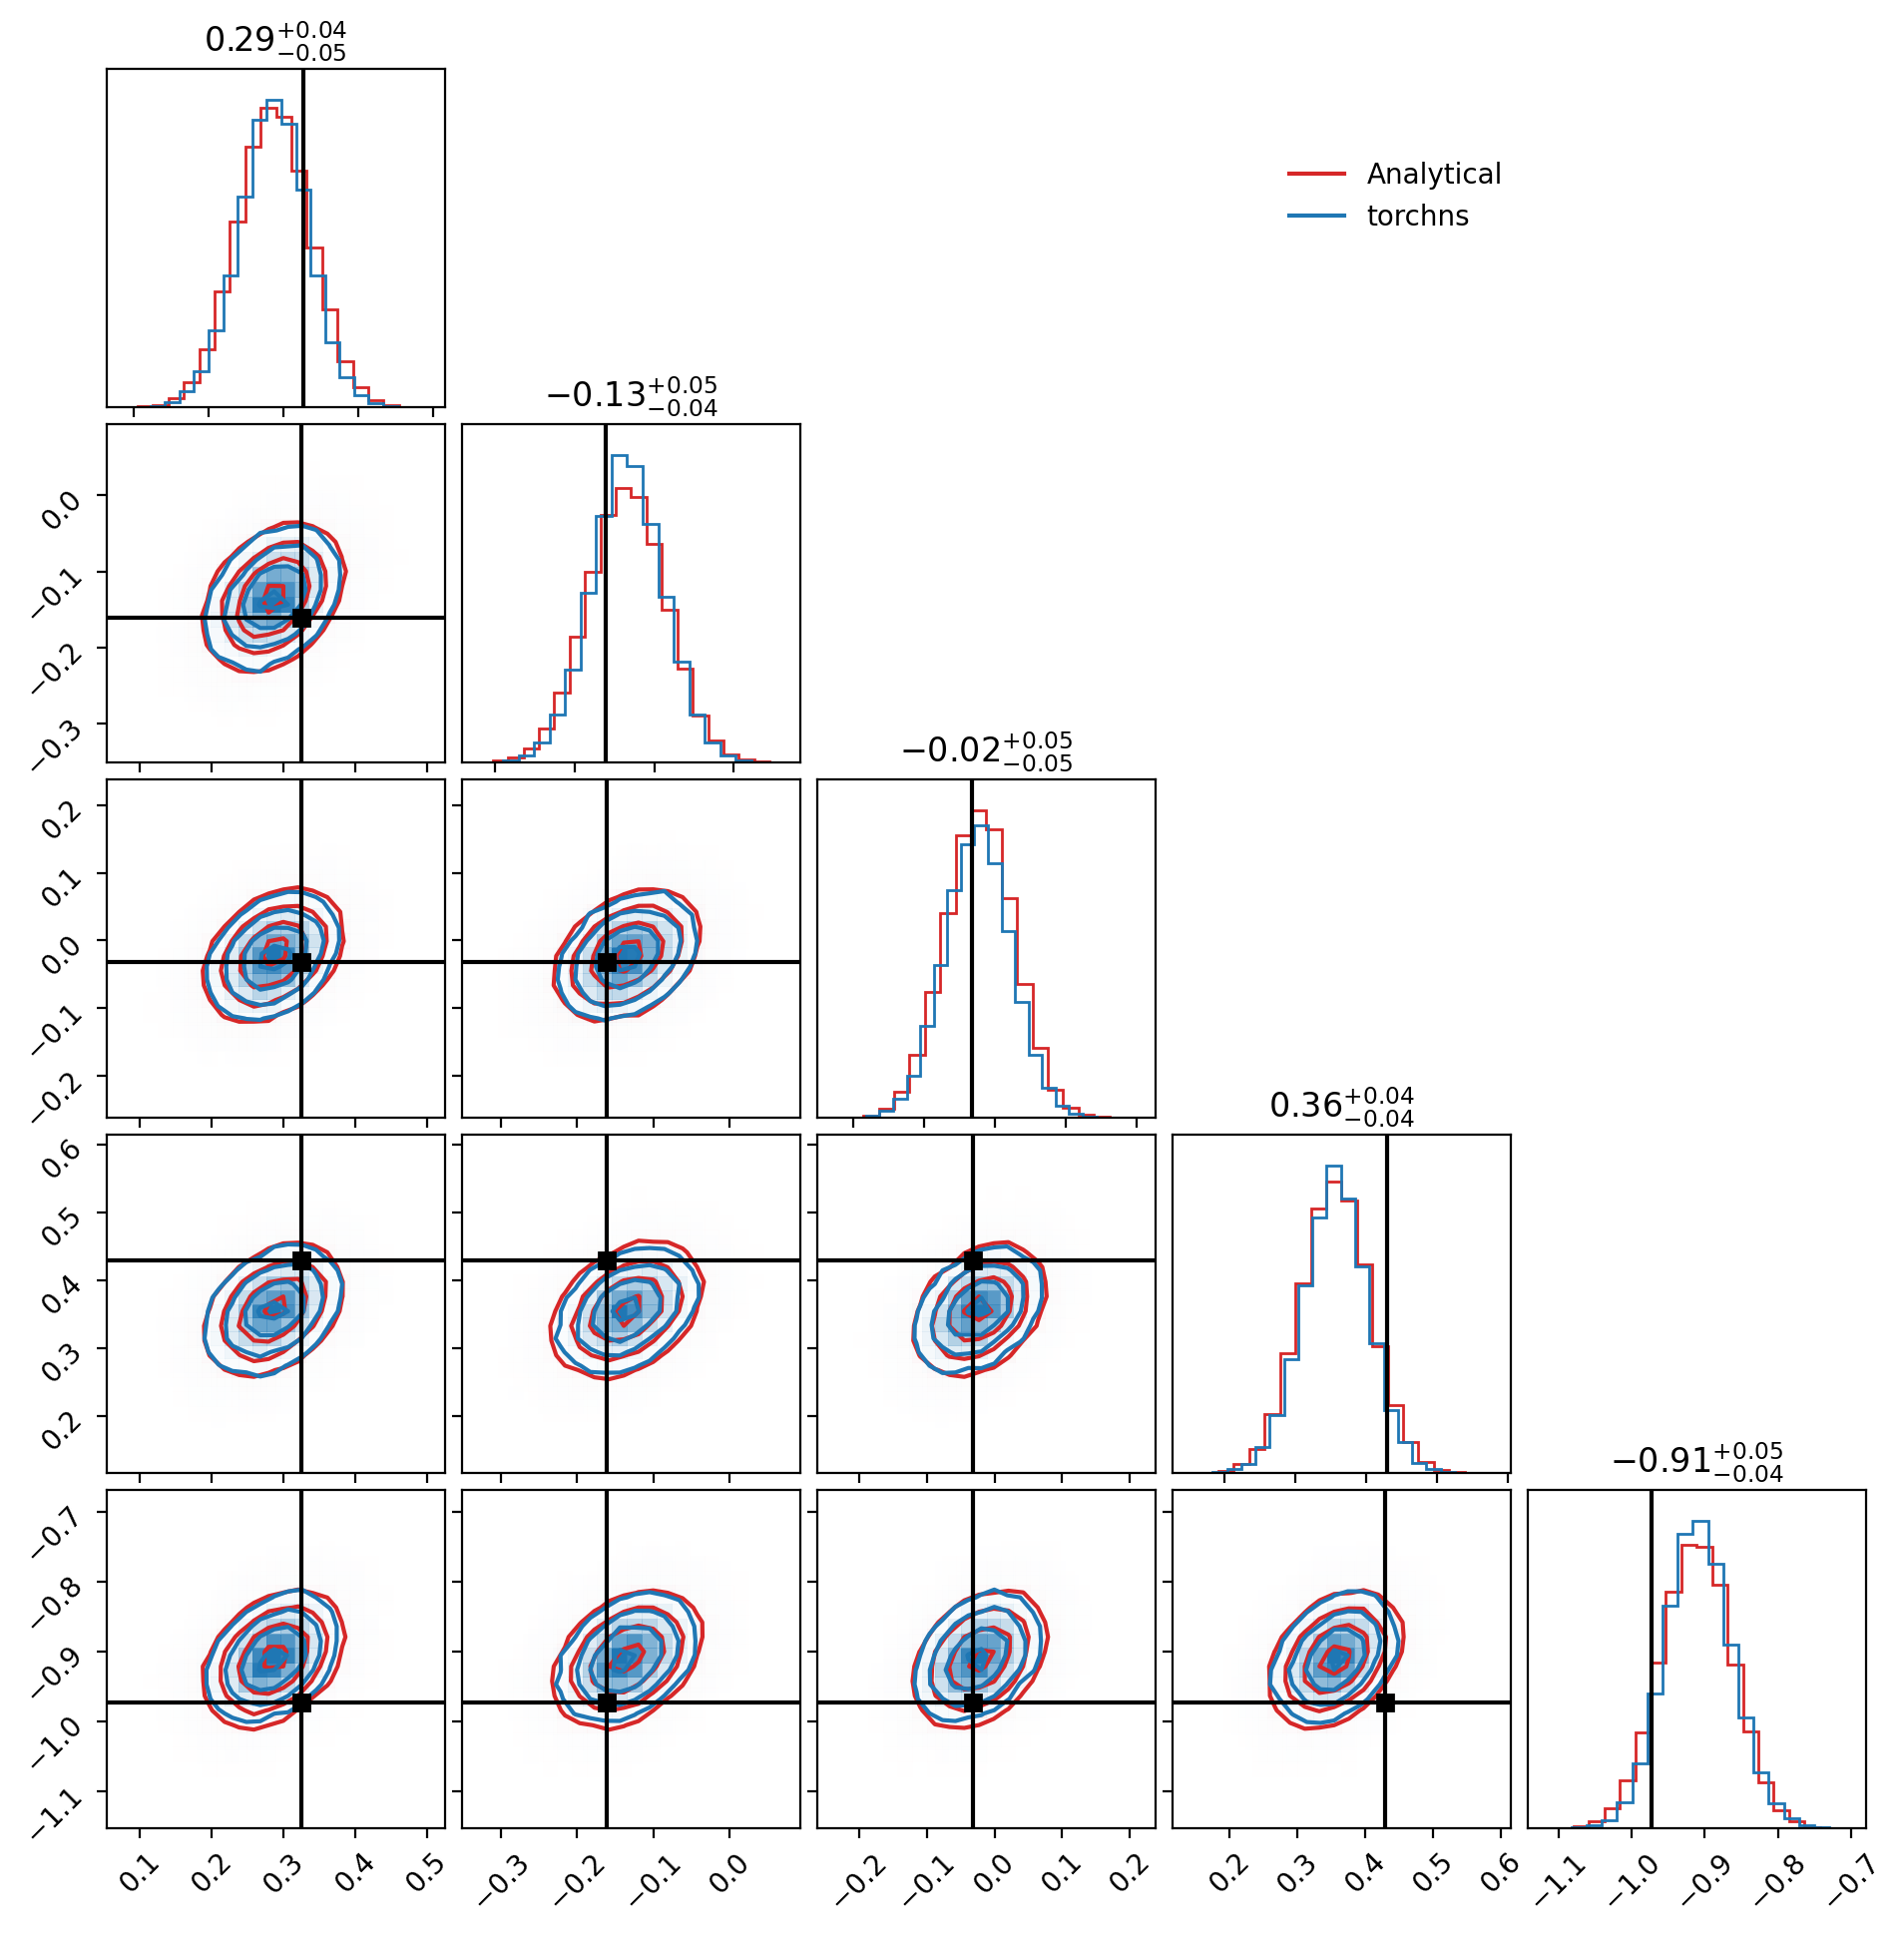

In [6]:
print("N_eff:", ns.get_posterior_neff())
X_post_ns, L_post_ns = ns.get_posterior_samples()
X_post_ns = prior_transform.u_to_v(X_post_ns)

X_post_analytical = posterior.sample((len(X_post_ns),))

fig = plt.figure(figsize=(2*dim,2*dim), dpi=200)
corner(X_post_analytical.numpy(), fig=fig, show_titles=True, plot_datapoints=False, color='tab:red')
corner(X_post_ns.numpy(), fig=fig, show_titles=True, plot_datapoints=False, color='tab:blue', truths=PARAMETERS.numpy(), truth_color='k')
plt.plot([], [], color='tab:red', label='Analytical')
plt.plot([], [], color='tab:blue', label='torchns')
plt.legend(frameon=False, bbox_to_anchor=(0, dim));

Compute discarded mass threshold

In [7]:
alpha = 1e-5
logl_th = ns.get_threshold(alpha)
print(f"Log-likelihood threshold for p={alpha}:", logl_th)

Log-likelihood threshold for p=1e-05: -4.346985454657391


Get constrained prior samples

In [8]:
X_cp, L_cp = ns.get_constrained_prior_samples(None, min_logl = logl_th)

Generate new constrained prior samples

In [9]:
X_cp, L_cp = ns.generate_constrained_prior_samples(
    lambda X: log_likelihood(X, prior_transform),
    N=10_000,
    min_logl=logl_th,
    batch_size=100
)

  0%|          | 0/100 [00:00<?, ?it/s]

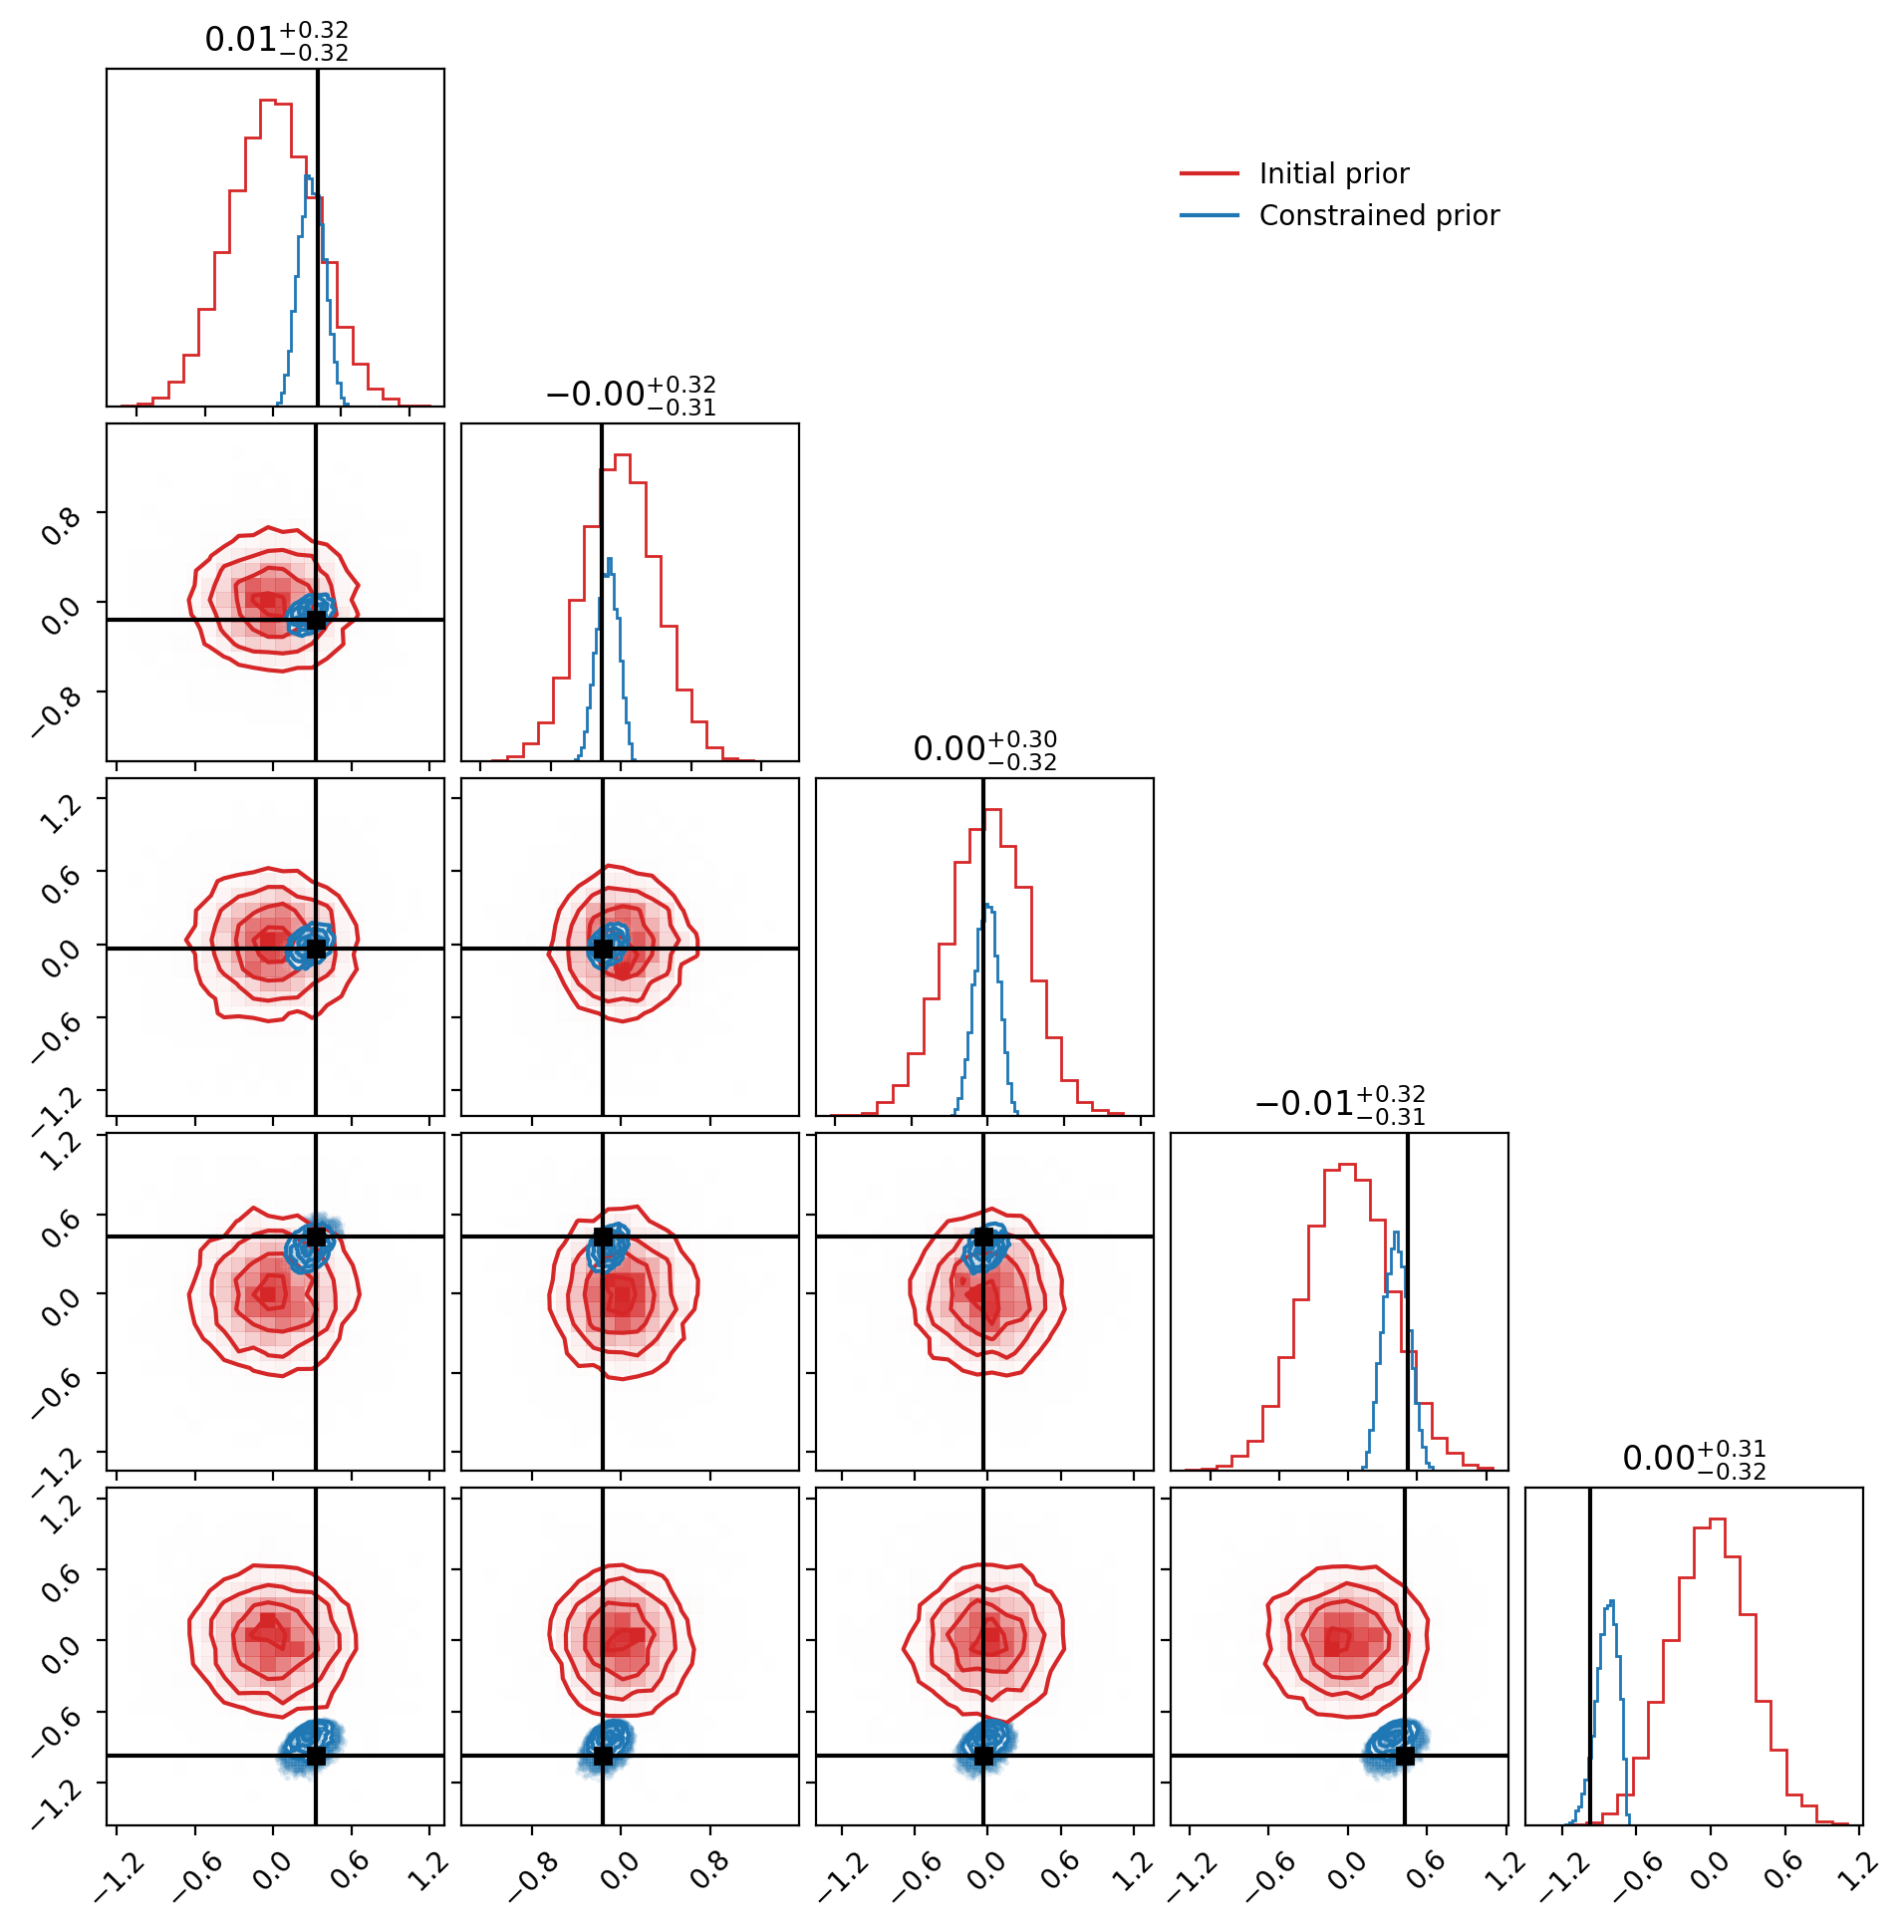

In [10]:
fig = plt.figure(figsize=(2 * dim,2 * dim), dpi=200)
corner(prior_transform.u_to_v(X_init).numpy(), fig=fig, show_titles=True, plot_datapoints=False, color='tab:red')
corner(prior_transform.u_to_v(X_cp).numpy(), fig=fig, color='tab:blue', truths=PARAMETERS.numpy(), truth_color='k')
plt.plot([], [], color='tab:red', label='Initial prior')
plt.plot([], [], color='tab:blue', label='Constrained prior')
plt.legend(frameon=False, bbox_to_anchor=(0, dim));